<a href="https://colab.research.google.com/github/naoya1110/ai_robotics_lab_2023_hands_on/blob/main/Week06_Practical_Techniques_for_Training_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NCKU-NITKC AI Robotics Lab - Week 06

## Introduction

In this notebook, we will learn about practical techniques for training convolutional neural network (CNN) models such as


*   Data Standardization
*   Data Augmentation
*   Dropout Layer
*   L1, L2 Regularization
*   Transfer Learning



 As we saw last week, deep neural network models can easily overfit. Therefore, we always have to be careful not to overfit our models during training. However, thanks to the intensive researches in this field, many practical techniques for avoiding overfitting have been discovered. In this notebook, we will implement some of these techniques and see how they work.

### GPU

We will use a GPU to train CNN models. Please make sure your runtime type is GPU (cuda).

In [ ]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

### General Packages

Let's import general Python packages.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

## Data Preparation

### CIFAR10

We will use CIFAR10 dataset again.

In [ ]:
from torchvision.datasets import CIFAR10

train_dataset = CIFAR10(root="cifar10", train=True, download=True)
test_dataset = CIFAR10(root="cifar10", train=False, download=True)

classnames = {0:"plane",
              1:"car",
              2:"bird",
              3:"cat",
              4:"deer",
              5:"dog",
              6:"frog",
              7:"horse",
              8:"ship",
              9:"truck"}

### Data Standardization (aka. z-score normalization)

Data rescaling is often used as a preprocessing step in data preparation. One of the data rescaling methods is standardization (aka. z-score normalization). A raw data $x_i$ will be converted to a standardized data $z_i$ by the equation below, where $\mu$ and $\sigma$ are mean and standard deviation of the raw dataset, respectively.

$\displaystyle z_i=\dfrac{x_i-\mu}{\sigma}$

By standardization, the mean and the standard deviation of the new dataset will be 0 and 1 respectively.

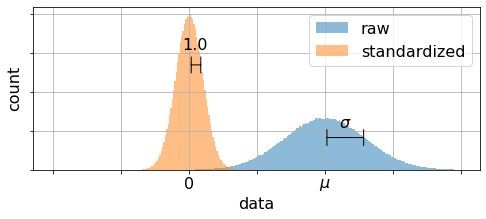

In order to standardize CIFAR10 image data, we need to know the means $\mu$ and the standard deviations $\sigma$ of red, green, blue pixels in the raw dataset. To do this, we first collect all red, green and blue pixels data in NumPy arrays.

In [ ]:
red_pixels = []
green_pixels = []
blue_pixels = []

for image, label in tqdm(train_dataset):
    image = np.array(image)/255.        # normalize data from 0-255 to 0.0-1.0
    image = image.astype("float32")

    red_pixels.append(image[:,:,0])     # take only red pixels
    green_pixels.append(image[:,:,1])   # take only green pixels
    blue_pixels.append(image[:,:,2])    # take only blue pixels

# convert data to 1D array
red_pixels = np.array(red_pixels).flatten()
green_pixels = np.array(green_pixels).flatten()
blue_pixels = np.array(blue_pixels).flatten()

print("number of red pixels", red_pixels.shape)
print("number of green pixels", green_pixels.shape)
print("number of blue pixels", blue_pixels.shape)

Let's take a look at their distributions.

In [ ]:
plt.figure(figsize=(5, 5))

bins = np.arange(0, 1.01, 0.05)

plt.subplot(3, 1, 1)
plt.hist(red_pixels, bins=bins, color="r", alpha=0.5)

plt.subplot(3, 1, 2)
plt.hist(green_pixels, bins=bins, color="g", alpha=0.5)

plt.subplot(3, 1, 3)
plt.hist(blue_pixels, bins=bins, color="b", alpha=0.5)

Now we can determine means of red, green and blue pixels.

In [6]:
means = (red_pixels.mean(), green_pixels.mean(), blue_pixels.mean())
means

(0.49139968, 0.48215827, 0.44653124)

Also standard deviations of red, green and blue pixels.

In [7]:
stds = (red_pixels.std(), green_pixels.std(), blue_pixels.std())
stds

(0.24703233, 0.24348505, 0.26158768)

Then we can standardize the raw dataset by using `means` and `stds` data, and see how the standardized dataset distributes.

In [ ]:
# standardization
red_pixels_z = (red_pixels-means[0])/stds[0]
green_pixels_z = (green_pixels-means[1])/stds[1]
blue_pixels_z = (blue_pixels-means[2])/stds[2]

# visualize distributions
plt.figure(figsize=(8, 3))

bins=np.arange(-3,3.1,0.2)

plt.subplot(2, 3, 1)
plt.hist(red_pixels, bins=bins, color="r", alpha=0.5)
plt.ylabel("original")

plt.subplot(2, 3, 2)
plt.hist(green_pixels, bins=bins, color="g", alpha=0.5)

plt.subplot(2, 3, 3)
plt.hist(blue_pixels, bins=bins, color="b", alpha=0.5)

plt.subplot(2, 3, 4)
plt.hist(red_pixels_z, bins=bins, color="r", alpha=0.5)
plt.ylabel("standardized")

plt.subplot(2, 3, 5)
plt.hist(green_pixels_z, bins=bins, color="g", alpha=0.5)

plt.subplot(2, 3, 6)
plt.hist(blue_pixels_z, bins=bins, color="b", alpha=0.5)

We will use the `means` and `stds` data later when we reload the CIFAR10 dataset with `torch.tensor` format.

### Data Augmentation

Another technique often used for preprocessing is data augmentation. Data augmentation is a very powerful technique for preventing overfitting, especially when number of training data is limited. In each training epoch, slightly modified copies of the images are generated from the original images. This is effective to prevent the model from just remembering the training data because the model will never see exactly the same data again. The data augmention can be implemented easily using `torchvision.transforms.v2` module.

Here we take one image from training data and let's see how this image can be augmented.

In [ ]:
image, label = train_dataset[1]

plt.figure(figsize=(5,3))
plt.rcParams["font.size"]=12
plt.imshow(image)
plt.title(classnames[label])

x = image

#### Random Horizontal Flip



In [ ]:
from torchvision.transforms import v2
transform = v2.RandomHorizontalFlip(p=0.5)

def show_transformed_images(transform, x):
    plt.figure(figsize=(12, 2))
    for i in range(5):
        output_image = transform(x)
        plt.subplot(1, 5, i+1)
        plt.imshow(output_image)

show_transformed_images(transform, x)

#### Random Vertical Flip

In [ ]:
transform = v2.RandomVerticalFlip(p=0.5)

show_transformed_images(transform, x)

#### Random Roation

In [ ]:
transform = v2.RandomRotation(degrees=60)

show_transformed_images(transform, x)

#### Random Perspective

In [ ]:
transform = v2.RandomPerspective(distortion_scale=0.3, p=1)

show_transformed_images(transform, x)

#### Compose Transforms
We can combine several different transoforms using `transform.Compose()`.

In [ ]:
transform = v2.Compose([
                v2.RandomHorizontalFlip(p=0.5),
                v2.RandomVerticalFlip(p=0.5),
                v2.RandomRotation(degrees=30),
                v2.RandomPerspective(distortion_scale=0.3, p=0.5)
                ])

show_transformed_images(transform, x)

There are lots of other transforms modules that can be used for data augmentation. Please refer the information below.

`torchvision.transforms` https://pytorch.org/vision/stable/transforms.html

### Reload Data

Now we reload CIFAR10 dataset in `torch.tensor` format. At the same time, we apply the data standardization and the data augmentation. The standardization should be applied for both of the train and the test data, but the data augmentation should be applied to the train data only.

In [ ]:
from torchvision.transforms import v2

train_dataset = CIFAR10(root="cifar10", train=True, download=False,
                        transform=v2.Compose([
                            v2.ToTensor(),               # convert to torch.tensor
                            # v2.Normalize(means, stds),   # standardization

                            # data augmentation
                            v2.RandomHorizontalFlip(p=0.5),
                            # v2.RandomVerticalFlip(p=0.5),
                            v2.RandomRotation(degrees=10),
                            v2.RandomPerspective(distortion_scale=0.3, p=0.5)
                            ])
                   )

test_dataset = CIFAR10(root="cifar10", train=False, download=False,
                        transform=v2.Compose([
                            v2.ToTensor(),                # convert to torch.tensor
                            # v2.Normalize(means, stds)     # standardization
                            ])
                   )

### DataLoader

Then we create `DataLoader` objects for feeding data to the model. This is exactly same as we did with Iris dataset.

In [25]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

That's it for data preparation!

## Model Building

### Design from Scratch

Next step is to build a convolutional neural network (CNN) and load it to GPU. The model we define here is identical to what we used last week, except for the dropout layer in the classifier.

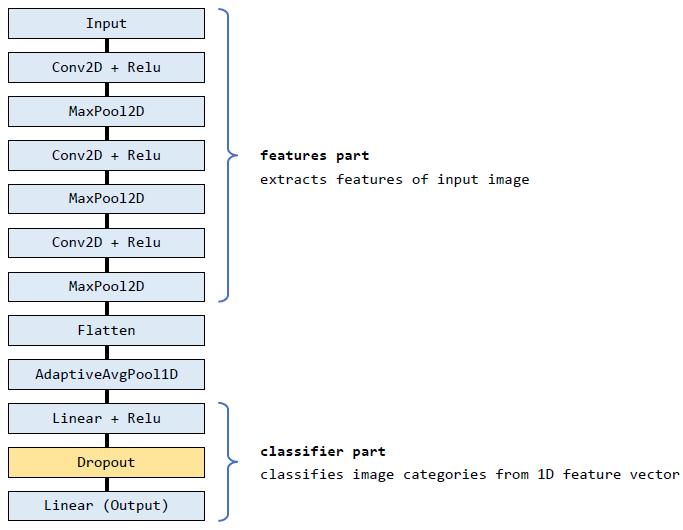

In [ ]:
import torch.nn as nn

# define a class named "Model"
class Model(nn.Module):

    # Constructor
    def __init__(self):                 # do not change
        super(Model, self).__init__()   # do not change

        # define a network module named "features"
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # define a network module named "junction"
        self.junction = nn.Sequential(
            nn.Flatten(),
            nn.AdaptiveAvgPool1d(output_size=512)
        )

        # define a network module named "classifier"
        self.classifier = nn.Sequential(
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256, out_features=10)
        )

    # Instance method
    def forward(self, x):   # do not change
        x = self.features(x)
        x = self.junction(x)
        x = self.classifier(x)
        return x

model = Model()    # construct an instance of the Model class
print(model)

#### Dropout Layer

The dropout layer makes some of the neurons from previous layer to be 0 randomly with the probability of `p` during training. Since less information will propagete through the dropout layer, the model will be trained under more difficult situation. This will make the model more rubust.

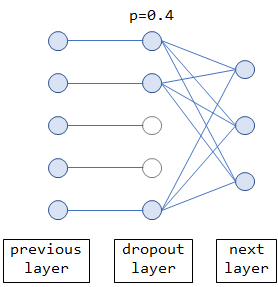

The dropout layer can be implemented with `nn.Dropout()`. The parameter `p` indicates the probabitlty of neurons to be 0 with a Bernoulli distribution. Also non-zero nodes will be scaled by a factor of 1/(1-p).

`nn.Dropout()` https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html

In [ ]:
x = torch.ones(10)
y = nn.Dropout(p=0.5)(x)
print("input", x)
print("output", y)

#### torchinfo
Let's see the model archtecture.

In [ ]:
! pip install torchinfo
from torchinfo import summary

for x_batch, _ in train_loader:
    break

input_shape = x_batch.shape
print(input_shape)

summary(model, input_shape)

### Use Pretrained Model (Transfer Learning)

So far, we have learned how to build and train deep neural network models from scratch. Transfer learning is a technique to shortcut some of these processes. Starting point of the transfer learning is a model already trained with other dataset. Such model is called a ***pretrained model***. Then the pretrained model will be trained with a new dataset. In some cases, only a part of parameters (weights and biases) in the pretrained model will be retrained while rest of them are fixed as pretrained. By employing the transfer learning, the model can reach higher performance with less training time compared with training it from scratch.

#### Load Pretrained Model
The pretrained models can be downloaded using `torchvison.models`. We will use a model called VGG16 which is one of the well-known image classification models. By specifying `vgg16(pretrained=True)`, we can load the VGG16 model pretrained with the dataset called ImageNet. ImageNet dataset consists of more than 1.2 million images with 1000 categories.

VGG16 Original Paper https://arxiv.org/abs/1409.1556

ImageNet Dataset https://www.image-net.org/update-mar-11-2021.php

In [ ]:
import torchvision.models as models

model = models.vgg16(pretrained=True)
print(model)

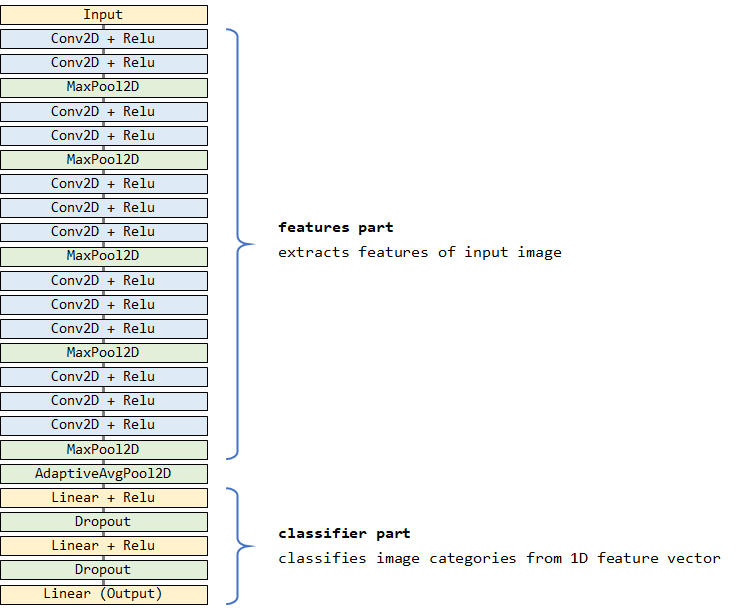

#### Replace Output Layer
The number of output neurons of the pretrained VGG16 model is 1000. This is because this model is designed for classifying 1000 categories of images.

In [ ]:
model.classifier[6]

Since we are going to classify CIFAR10 dataset, the number of output neurons needs to be 10. Therefore we have to replace the last layer.

In [ ]:
model.classifier[6] = nn.Linear(4096, 10)   # replace the last layer
print(model)

### Freeze Parameters
The pretrained VGG16 model is well-trained with the ImageNet dataset, therefore the model parapeters (weights and biases) are already good for general image classification tasks. In such case, it might be better to keep (freeze) most of the parameters in the model and re-train only a few layers of the model with the new dataset.

In order to do so, we make all of the parameters in the model to be frozen by setting `requires_grad=False`.

In [ ]:
for param in model.parameters():
    param.requires_grad = False

Then we set `requires_grad=Ture` to some specific layers so that they will be trained.

For example if we want to train only the parameters in the last layer (`model.classfier[6]`, 6th layer in the classifier part), we can do

In [ ]:
model.classifier[6].weight.requires_grad = True
model.classifier[6].bias.requires_grad = True

If we want to train other layers, we can do like

In [ ]:
# 0th layer in the classifier part
model.classifier[0].weight.requires_grad = True
model.classifier[0].bias.requires_grad = True

# 3rd layer in the classifier part
model.classifier[3].weight.requires_grad = True
model.classifier[3].bias.requires_grad = True

### torchinfo
Let's see how the data shape changes in the model.

In [ ]:
! pip install torchinfo
from torchinfo import summary

for x_batch, _ in train_loader:
    break

input_shape = x_batch.shape
print(input_shape)

summary(model, input_shape)

## Training

### Loss Function

We use the cross-entropy loss as the loss function since this is a classification task.

In [30]:
loss_func = nn.CrossEntropyLoss()

### Optimizer

We use the Adam optimizer.

In [31]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1E-3)

### L1/L2 Regularization

L1 and L2 regularizations are implemented by adding a parameter norm penalty $\Omega$ to the loss value $\mathrm{loss}_0$ that is determined by the loss function such as `nn.CrossEntropyLoss()` as shown below.

$\mathrm{loss} = \mathrm{loss}_0 + \alpha\Omega$

where $\alpha$ is the relative contribution factor of $\Omega$.

#### L2 Norm Penalty
L2 norm penalty $\Omega_{L2}$ is adding-up by cumulating the squared value of all weights in the model as shown below.

$\displaystyle \Omega_{L2}=\sum_i w_i^2$

In [ ]:
def get_l2_norm(model=model):
    l2_norm = 0
    for p in model.parameters():
        l2_norm += p.pow(2).sum()
    return l2_norm

print("L2 Norm Penalty:", get_l2_norm(model).item())

#### L1 Regularization
L1 norm penalty $\Omega_{L1}$ is calculated by cumulating the absolute value of all weights in the model as shown below.

$\displaystyle \Omega_{L1}=\sum_{i} |w_i|$

In [ ]:
def get_l1_norm(model=model):
    l1_norm = 0
    for p in model.parameters():
        l1_norm += p.abs().sum()
    return l1_norm

print("L1 Norm Penalty:", get_l1_norm(model).item())

### Save Model Parameters

It is also a good idea to save the model parameters during the training so that we can load it later. We can do this with the code below.

In [ ]:
model_path = "my_model.pth"
torch.save(model.state_dict(), model_path)

### Training Loop

Now we can train the model.

This time we save the model parameters after each epoch if the test accuracy is better than before. Then later we can load the best model.







In [34]:
model_selection = "scratch" # "scratch" or "pretrained"


if model_selection == "scratch":
    model = Model() # use model designed from scratch

elif model_selection == "pretrained":
    model = models.vgg16(pretrained=True)            # load pretrained model
    model.classifier[6] = nn.Linear(4096, 10)        # replace the last Linear layer

    for param in model.parameters():                 # freeze all parameters
        param.requires_grad = False

    # enable training for the specific layers
    model.classifier[3].weight.requires_grad = True
    model.classifier[3].bias.requires_grad = True
    model.classifier[6].weight.requires_grad = True
    model.classifier[6].bias.requires_grad = True

model = model.to(device)                                # load model on GPU
loss_func = nn.CrossEntropyLoss()                      # set loss function
optimizer = optim.Adam(model.parameters(), lr=1E-3)    # set optimizer
epochs = 30

best_model_path = 'best_model.pth'
best_accuracy = 0.0

# create empty lists for saving metrics during training
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []

for epoch in range(epochs):
    print("-----------------------------")
    print(f"Epoch {epoch+1}/{epochs}")

    # initialize metrics
    train_correct_count = 0
    train_accuracy = 0
    train_loss = 0
    test_correct_count = 0
    test_accuracy = 0
    test_loss = 0

    #--- Training Phase ---#
    model.train()    # set model to training mode

    pbar = tqdm(train_loader)
    pbar.set_description("Train")

    for x_batch, y_batch in pbar:      # take mini batch data from train_loader

        x_batch = x_batch.to(device)     # load x_batch data on GPU
        y_batch = y_batch.to(device)     # load y_batch data on GPU

        optimizer.zero_grad()                  # reset gradients to 0
        p_batch = model(x_batch)               # do prediction
        loss = loss_func(p_batch, y_batch)     # measure loss

        #--- L1/L2 regularizaiton ---#
        # alpha = 0.001
        # loss = loss + alpha * get_l2_norm(model)    # add L2 penalty
        # loss = loss + alpha * get_l1_norm(model)  # add L1 penalty
        #----------------------------#

        loss.backward()                        # calculate gradients
        optimizer.step()                       # update model parameters

        train_loss += loss.item()                                # accumulate loss value
        p_batch_label = torch.argmax(p_batch, dim=1)             # convert p_batch vector to p_batch_label
        train_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #----------------------#

    #--- Evaluation Phase ---#
    with torch.no_grad():   # disable autograd for saving memory usage
        model.eval()        # set model to evaluation mode

        pbar = tqdm(test_loader)
        pbar.set_description("Test")

        for x_batch, y_batch in pbar:   # take mini batch data from test_loader

            x_batch = x_batch.to(device)     # load x_batch data on GPU
            y_batch = y_batch.to(device)     # load y_batch data on GPU

            p_batch = model(x_batch)              # do prediction
            loss = loss_func(p_batch, y_batch)    # measure loss

            #--- L1/L2 regularizaiton ---#
            # loss = loss + alpha * get_l2_norm(model)    # add L2 penalty
            # loss = loss + alpha * get_l1_norm(model)  # add L1 penalty
            #----------------------------#

            test_loss += loss.item()                                # add up loss value

            p_batch_label = torch.argmax(p_batch, dim=1)            # convert p_batch vector to p_batch_label
            test_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

            pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #------------------------#

    train_accuracy = train_correct_count.item()/len(train_dataset)   # determine accuracy for training data
    test_accuracy = test_correct_count.item()/len(test_dataset)      # determine accuracy for test data
    train_loss = train_loss/len(train_loader)                 # determine loss for training data
    test_loss = test_loss/len(test_loader)                    # determine loss for test data

    # show and store metrics
    print(f"Train: Accuracy={train_accuracy:.3f} Loss={train_loss:.3f}, Test: Accuracy={test_accuracy:.3f} Loss={test_loss:.3f}")
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    test_accuracy_list.append(test_accuracy)
    test_loss_list.append(test_loss)

    # save the model if test accuracy is better than before
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), best_model_path)
        print(f"Test accuracy improved from {best_accuracy:.3f} to {test_accuracy:.3f}")
        print(f"Model saved at {best_model_path}")
        best_accuracy = test_accuracy

-----------------------------
Epoch 1/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.316 Loss=1.824, Test: Accuracy=0.438 Loss=1.511
Test accuracy improved from 0.000 to 0.438
Model saved at best_model.pth
-----------------------------
Epoch 2/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.444 Loss=1.500, Test: Accuracy=0.515 Loss=1.324
Test accuracy improved from 0.438 to 0.515
Model saved at best_model.pth
-----------------------------
Epoch 3/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.494 Loss=1.381, Test: Accuracy=0.550 Loss=1.239
Test accuracy improved from 0.515 to 0.550
Model saved at best_model.pth
-----------------------------
Epoch 4/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.536 Loss=1.279, Test: Accuracy=0.600 Loss=1.108
Test accuracy improved from 0.550 to 0.600
Model saved at best_model.pth
-----------------------------
Epoch 5/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.568 Loss=1.199, Test: Accuracy=0.629 Loss=1.040
Test accuracy improved from 0.600 to 0.629
Model saved at best_model.pth
-----------------------------
Epoch 6/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.594 Loss=1.135, Test: Accuracy=0.614 Loss=1.061
-----------------------------
Epoch 7/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.616 Loss=1.080, Test: Accuracy=0.669 Loss=0.928
Test accuracy improved from 0.629 to 0.669
Model saved at best_model.pth
-----------------------------
Epoch 8/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.633 Loss=1.033, Test: Accuracy=0.690 Loss=0.885
Test accuracy improved from 0.669 to 0.690
Model saved at best_model.pth
-----------------------------
Epoch 9/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.653 Loss=0.977, Test: Accuracy=0.681 Loss=0.895
-----------------------------
Epoch 10/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.666 Loss=0.946, Test: Accuracy=0.695 Loss=0.872
Test accuracy improved from 0.690 to 0.695
Model saved at best_model.pth
-----------------------------
Epoch 11/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.683 Loss=0.905, Test: Accuracy=0.712 Loss=0.821
Test accuracy improved from 0.695 to 0.712
Model saved at best_model.pth
-----------------------------
Epoch 12/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.696 Loss=0.873, Test: Accuracy=0.735 Loss=0.757
Test accuracy improved from 0.712 to 0.735
Model saved at best_model.pth
-----------------------------
Epoch 13/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.704 Loss=0.843, Test: Accuracy=0.741 Loss=0.744
Test accuracy improved from 0.735 to 0.741
Model saved at best_model.pth
-----------------------------
Epoch 14/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.715 Loss=0.815, Test: Accuracy=0.748 Loss=0.719
Test accuracy improved from 0.741 to 0.748
Model saved at best_model.pth
-----------------------------
Epoch 15/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.720 Loss=0.800, Test: Accuracy=0.755 Loss=0.693
Test accuracy improved from 0.748 to 0.755
Model saved at best_model.pth
-----------------------------
Epoch 16/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.729 Loss=0.776, Test: Accuracy=0.754 Loss=0.706
-----------------------------
Epoch 17/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.740 Loss=0.754, Test: Accuracy=0.752 Loss=0.711
-----------------------------
Epoch 18/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.741 Loss=0.742, Test: Accuracy=0.749 Loss=0.736
-----------------------------
Epoch 19/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.748 Loss=0.723, Test: Accuracy=0.773 Loss=0.663
Test accuracy improved from 0.755 to 0.773
Model saved at best_model.pth
-----------------------------
Epoch 20/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.756 Loss=0.708, Test: Accuracy=0.778 Loss=0.648
Test accuracy improved from 0.773 to 0.778
Model saved at best_model.pth
-----------------------------
Epoch 21/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.760 Loss=0.690, Test: Accuracy=0.782 Loss=0.638
Test accuracy improved from 0.778 to 0.782
Model saved at best_model.pth
-----------------------------
Epoch 22/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.765 Loss=0.678, Test: Accuracy=0.782 Loss=0.645
-----------------------------
Epoch 23/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.767 Loss=0.671, Test: Accuracy=0.783 Loss=0.632
Test accuracy improved from 0.782 to 0.783
Model saved at best_model.pth
-----------------------------
Epoch 24/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.773 Loss=0.661, Test: Accuracy=0.789 Loss=0.618
Test accuracy improved from 0.783 to 0.789
Model saved at best_model.pth
-----------------------------
Epoch 25/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.778 Loss=0.645, Test: Accuracy=0.785 Loss=0.623
-----------------------------
Epoch 26/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.780 Loss=0.641, Test: Accuracy=0.790 Loss=0.618
Test accuracy improved from 0.789 to 0.790
Model saved at best_model.pth
-----------------------------
Epoch 27/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.783 Loss=0.626, Test: Accuracy=0.794 Loss=0.603
Test accuracy improved from 0.790 to 0.794
Model saved at best_model.pth
-----------------------------
Epoch 28/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.785 Loss=0.618, Test: Accuracy=0.793 Loss=0.612
-----------------------------
Epoch 29/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.790 Loss=0.610, Test: Accuracy=0.796 Loss=0.596
Test accuracy improved from 0.794 to 0.796
Model saved at best_model.pth
-----------------------------
Epoch 30/30


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Train: Accuracy=0.791 Loss=0.608, Test: Accuracy=0.802 Loss=0.591
Test accuracy improved from 0.796 to 0.802
Model saved at best_model.pth


### Learning Curves

Let's visualize the accuracy and the loss curves for train and test data.

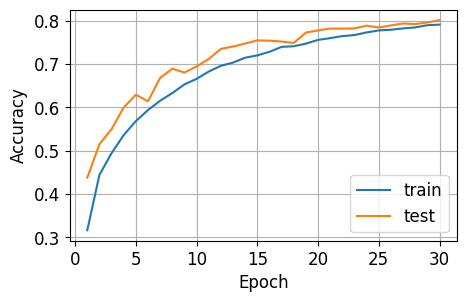

In [35]:
plt.figure(figsize=(5,3))
plt.rcParams["font.size"]=12
plt.plot(np.arange(epochs)+1, train_accuracy_list, label="train")
plt.plot(np.arange(epochs)+1, test_accuracy_list, label="test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

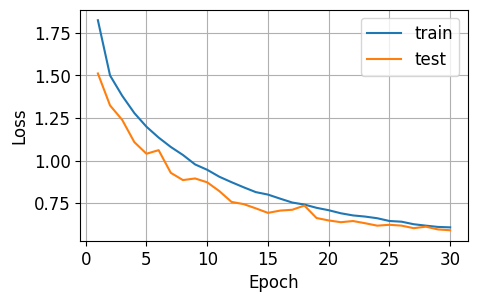

In [36]:
plt.figure(figsize=(5,3))
plt.rcParams["font.size"]=12
plt.plot(np.arange(epochs)+1, train_loss_list, label="train")
plt.plot(np.arange(epochs)+1, test_loss_list, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

As you see above, the test accuracy keeps increasing at least up to 10 epochs and is still higher than the train accuracy. Similarly the test loss keeps decreasing up to at least 10 epochs and still lower than the test loss. This is a sign of that the model is not overfitted yet. Therefore we can continue training the model further or we can use a larger model.

## Evaluation

### Load the Best Model

Now we can load the best model. What we saved in `best_model.pth` is only the model parameters. So first we need to load an initialized (not trained) model and then load the trained model parameters in there.

In [37]:
if model_selection == "scratch":
    model = Model() # use model designed from scratch

elif model_selection == "pretrained":
    model = models.vgg16(pretrained=False)            # load pretrained model
    model.classifier[6] = nn.Linear(4096, 10)        # replace the last Linear layer

model = model.to(device)                           # load an initialized model
model.load_state_dict(torch.load(best_model_path))   # load model parameters to the initialized model

<All keys matched successfully>

### Test Accuracy

We should check accuracy of the model for all of the test data.

In [38]:
test_accuracy = 0

y_test_all = np.array([])
p_label_all = np.array([])

with torch.no_grad():    # disable autograd
    model.eval()         # set model to evaluation mode

    for x_batch, y_batch in test_loader:    # take mini batch data from train_loader
        x_batch = x_batch.to(device)        # transfer x_batch to gpu
        y_batch = y_batch.to(device)        # transfer y_batch to gpu
        p_batch = model(x_batch)            # do prediction

        p_batch_label = torch.argmax(p_batch, dim=1)       # convert p_batch vector to p_batch_label
        test_accuracy += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        y_test_all = np.append(y_test_all, y_batch.to("cpu").numpy())          # append y_batch in y_test_all
        p_label_all = np.append(p_label_all, p_batch_label.to("cpu").numpy())  # append p_batch_label in p_label_all

test_accuracy = test_accuracy/len(test_dataset)      # determine accuracy for test data
print(f"Test Accuracy = {test_accuracy:.3f}")

Test Accuracy = 0.802


### Confusion Matrix

Then let's check the confusion matrix.

Text(0.5, 1.0, 'confusion matrix')

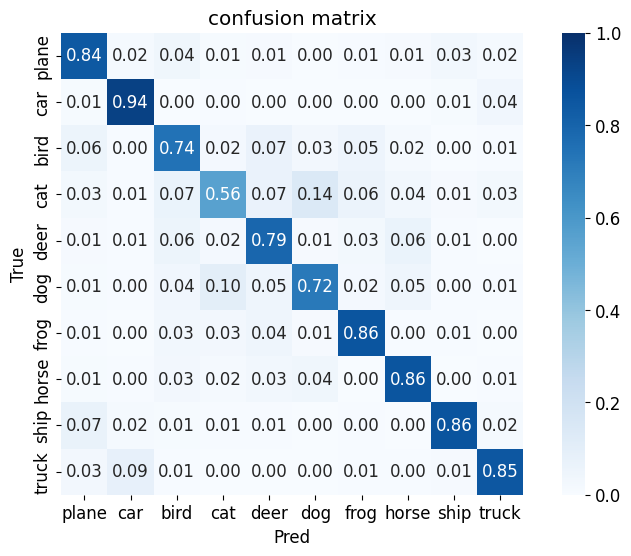

In [39]:
from sklearn.metrics import confusion_matrix

cmx = confusion_matrix(y_test_all, p_label_all)

cmx_pct = np.zeros(cmx.shape)

for i in range(cmx.shape[0]):
    for j in range(cmx.shape[1]):
        cmx_pct[i, j] = cmx[i, j]/cmx[i, :].sum()

plt.figure(figsize=(10,6))
labels = classnames.values()

sns.heatmap(cmx_pct, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1,
            xticklabels=classnames.values(), yticklabels=classnames.values(), square=True)

plt.ylabel("True")
plt.xlabel("Pred")
plt.title("confusion matrix")

### Predictions for Test Data

Let's see predictions for some test data.

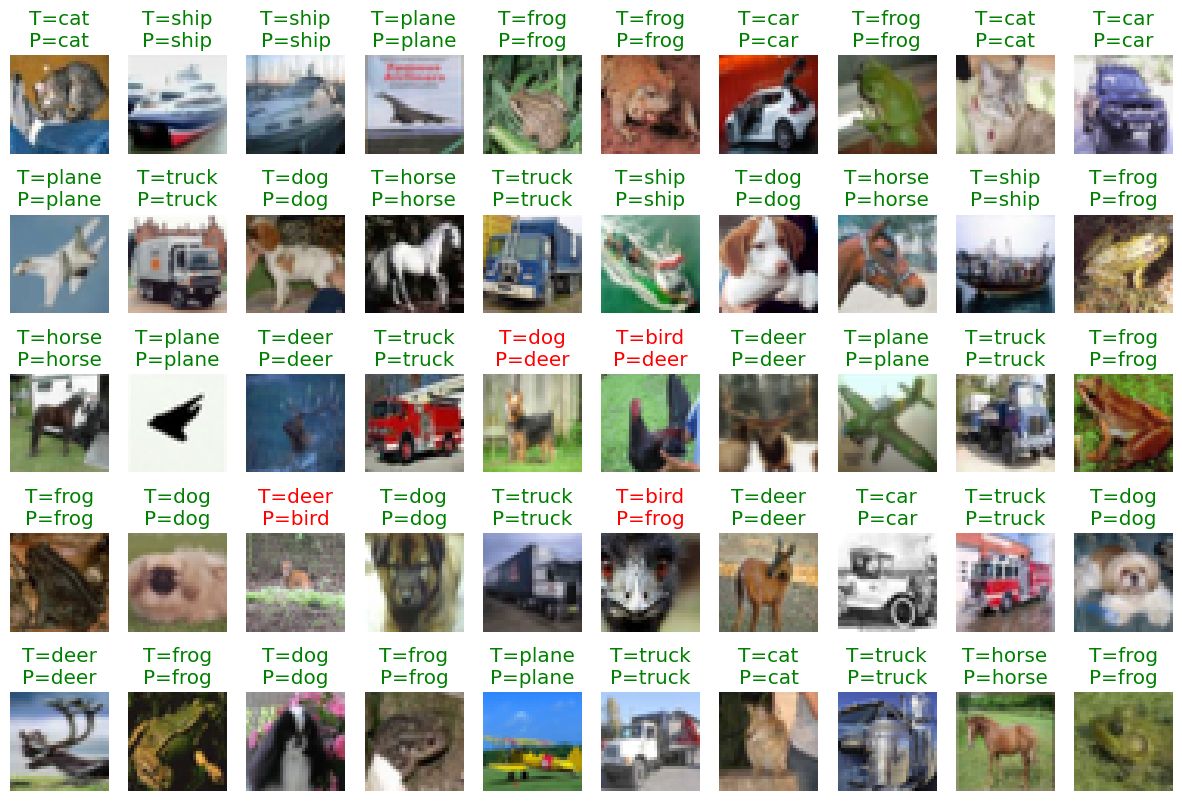

In [40]:
plt.figure(figsize=(15, 10))

for i in range(50):
    image, _ = test_dataset[i]
    image = np.transpose(image, (1,2,0))

    # if data standardization was applied, uncomment following three lines
    # image[:, :, 0] = image[:, :, 0]*stds[0]+means[0]
    # image[:, :, 1] = image[:, :, 1]*stds[1]+means[1]
    # image[:, :, 2] = image[:, :, 2]*stds[2]+means[2]

    plt.subplot(5, 10, i+1)
    plt.imshow(image)

    true_class = classnames[y_test_all[i]]
    pred_class = classnames[p_label_all[i]]
    if true_class == pred_class:
        color = "green"
    else:
        color = "red"
    plt.title(f"T={true_class}\nP={pred_class}", color=color)
    plt.axis("off")

## Conclusion
That's it for this week. Now you can try to improve the test accuracy by changing data augmentation methods, model architecture, training epochs and so on...